# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learnded for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our owm.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own,
then we can adapt those patterns to our own data

In [ ]:
#we using a gpu?
!nvidia-smi

Wed Oct 27 13:19:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and become one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2021-10-27 13:23:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 142.250.152.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   150MB/s    in 1.1s    

2021-10-27 13:23:08 (150 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

#Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)}, directories and {len(filenames)} images in '{dirpath}'.")

There are 2, directories and 0 images in '10_food_classes_10_percent'.
There are 10, directories and 0 images in '10_food_classes_10_percent/train'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0, directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0, directories and 75 images in '10_food_classes_10_

## Creating data loader (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32
#EPOCHS =5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent  = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical"
)

print("Testing images:")
test_data  = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical"
)




Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model train)

extra fucntionality you can add to your models to be performed during or after training. Some of the mose popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint call back
* Stopping a model from taining (before it trains to long and over fits) with early stopping callbacks


In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
   log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
   tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
   print(f"Saving TensorBoard log files to: {log_dir}")
   return tensorboard_callback
   

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

now were going to do a simila process, except the majority of pur model's layers are going to come from TensorFLow Hub

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorfLOW hUB PAGE AND sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Lets compare the two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A tensorflow Hub deature extraction URL.
  num_classes (int): Number of output neurons in the output layer,
  should be equal to number of target classes, default 10.

  Returns:
   An uncompiled Keras Sequential model with model_url as feature extractor
   layer and Dense output layer with num_classes output neurons.
 """
 # Download the pretrained model and save it 
  feature_extraction_layer = hub.KerasLayer(model_url, 
                                    trainable=False, # freeze the already learnded patterns
                                    name="feature_extraction_layer",
                                    input_shape=IMG_SHAPE+(3,)) 
  #create our own model
  model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model



### Creating and testing ResNet Tensorflow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Lets fit our resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps = len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V4")]
)

Saving TensorBoard log files to: tensorflow_hub/resnet50V4/20211027-144748
Epoch 1/5
24/24 [==============================] - 59s 1s/step - loss: 2.0298 - accuracy: 0.3520 - val_loss: 1.2271 - val_accuracy: 0.6112
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 0.9519 - accuracy: 0.7093 - val_loss: 0.8700 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 22s 922ms/step - loss: 0.6354 - accuracy: 0.8147 - val_loss: 0.7634 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 21s 927ms/step - loss: 0.4850 - accuracy: 0.8773 - val_loss: 0.7064 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 22s 930ms/step - loss: 0.3983 - accuracy: 0.9120 - val_loss: 0.6899 - val_accuracy: 0.7724


Wow!

That is Incredible Our transfer learning feature extractor
model utperformed ALL of the previous models we built by hande (substantially)
and in a quicker training time and with only 10 percent of the ttraining examples.

In [ ]:
#Lets create a function to plot our loss curves
# tidbit: you could put a function like this into a script into a script called "helper.py" and import it when you need it
#from helper import plot_loss_curves...

import matplotlib.pyplot as plt

#Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
   history: TensorFlow History object.

  Returns:
   PLots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss  = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.figure()
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  
  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();



   


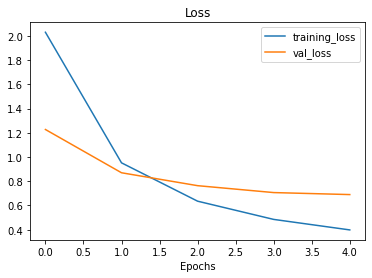

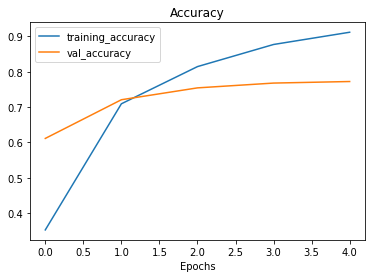

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
# details on efficient net https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

efficientnet_model = create_model(
    model_url=efficient_url,
    num_classes=train_data_10_percent.num_classes
)

# Compile EfficientNet model
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

EPOCHS=5

#Fit effnet model to a 10% of training data
efficient_history = efficientnet_model.fit(train_data_10_percent,
                                        epochs=EPOCHS,steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20211027-152000
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.9005 - accuracy: 0.4427 - val_loss: 1.3343 - val_accuracy: 0.7300
Epoch 2/5
24/24 [==============================] - 20s 869ms/step - loss: 1.0935 - accuracy: 0.7693 - val_loss: 0.8829 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 20s 871ms/step - loss: 0.7687 - accuracy: 0.8333 - val_loss: 0.7039 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 20s 873ms/step - loss: 0.6137 - accuracy: 0.8667 - val_loss: 0.6155 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 20s 871ms/step - loss: 0.5170 - accuracy: 0.8853 - val_loss: 0.5566 - val_accuracy: 0.8648


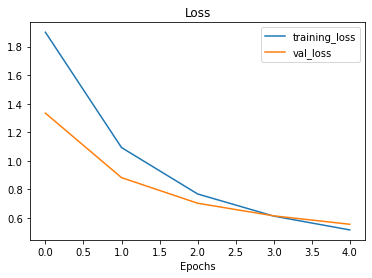

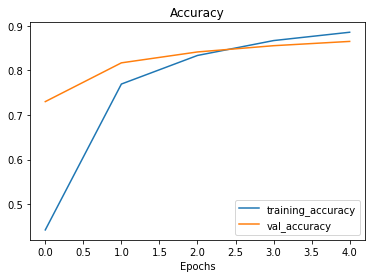

In [ ]:
plot_loss_curves(efficient_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **`As is" transfer learning`** - Using an existing model with no chnages whatsoever(eg using ImageNet model on 1000 ImageNet classes, none of your own)

* **`Feature extraction`** transfer learning - use the prelearnded patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for
 your own problem (e.g 1000 classes -> 10 classes of food)

* **`Fine-tuning`** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)



## Comparing our models results using TensorBoard

 **Note:** When you  upload things to tensorboard.dev, your experiments are public. So if youre running private exoeriments (that you don't want others to see) do not upload then to TensorBoard.dev.

In [ ]:
#Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


2021-10-27 15:51:51.792812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 15:51:51.953185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 15:51:51.953654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

Our TensorBoard experiments are uploaded publically here https://tensorboard.dev/experiment/LgONXZ7dR6KsD6edjg1ZpQ/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-10-27 15:57:01.659839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 15:57:01.668709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 15:57:01.669263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/LgONXZ7dR6KsD6edjg1ZpQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   LgONXZ7dR6KsD6edjg1ZpQ
	Created              2021-10-27 15:52:52 (4 minutes ago)
	Up

In [ ]:
#Delete an experiment
# !tensorboard dev delete --experiment_id LgONXZ7dR6KsD6edjg1ZpQ

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
#!tensorboard dev list